In [1]:
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import scipy.stats as stats
import utils
import pandas_market_calendars as mcal

In [2]:
ampm = 'morning'
path = f'{ampm}_df_*.csv'

all_files = glob.glob(path)

li = []

for filename in tqdm(all_files):
    df = pd.read_csv(filename, index_col=None, header=0,parse_dates=['time'])
    li.append(df)
    
df = pd.concat(li, axis=0, ignore_index=True)
df = df.set_index('time')
df = df.sort_index()

100%|██████████| 5/5 [00:00<00:00, 35.13it/s]


In [3]:
df = df.drop(['gaps','weekday'],axis=1)

In [4]:
nyse = mcal.get_calendar('NYSE')
working_days = nyse.valid_days(start_date='2016-01-01', end_date='2019-12-31')

In [5]:
len(df.groupby(df.index.date))

1209

In [6]:
working_days.date

array([datetime.date(2016, 1, 4), datetime.date(2016, 1, 5),
       datetime.date(2016, 1, 6), ..., datetime.date(2019, 12, 27),
       datetime.date(2019, 12, 30), datetime.date(2019, 12, 31)],
      dtype=object)

In [7]:
ngroups  = len(df.groupby(df.index.date))
count = 0
wd_only = []
for group in df.groupby(df.index.date):
    if working_days.date[working_days.date == group[0]].any():
        wd_only.append(group[1])
        count += 1
df = pd.concat(wd_only, axis=0, ignore_index=False)
count/ngroups

0.6261373035566584

In [8]:
(df['tmpf']<32).astype(int)

time
2016-01-04 04:00:00    0
2016-01-04 04:15:00    0
2016-01-04 04:30:00    0
2016-01-04 04:45:00    0
2016-01-04 05:00:00    0
                      ..
2019-12-30 11:00:00    0
2019-12-30 11:15:00    0
2019-12-30 11:30:00    0
2019-12-30 11:45:00    0
2019-12-30 12:00:00    0
Name: tmpf, Length: 24981, dtype: int64

In [9]:
df_norm = df.copy()

below_freezing = (df_norm['tmpf']<32).astype(int)
df_norm['lt_32'] = below_freezing

df_norm['p01i'] = df_norm['p01i']**(1/3)

In [10]:
df_norm = (df_norm-df_norm.mean())/df_norm.std()

In [11]:
df_norm = df_norm.bfill()
df_norm = df_norm.interpolate('linear')

df_norm.to_csv(f'merged_df_{ampm}.csv')

In [12]:
len(df_norm[df_norm['lt_32']>1])/4

629.25

In [13]:
df_norm[df_norm['lt_32']>1].corr()

,p01i,tmpf,speed,hour,speed_diff,lt_32
p01i,1.000000e+00,1.752784e-01,-2.825913e-01,-4.526835e-02,2.398944e-02,-1.694856e-15
tmpf,1.752784e-01,1.000000e+00,-1.123862e-01,2.084798e-02,-4.206663e-03,7.105100e-14
speed,-2.825913e-01,-1.123862e-01,1.000000e+00,-8.013216e-03,6.145689e-02,6.163049e-16
hour,-4.526835e-02,2.084798e-02,-8.013216e-03,1.000000e+00,-2.789435e-01,4.240777e-16
speed_diff,2.398944e-02,-4.206663e-03,6.145689e-02,-2.789435e-01,1.000000e+00,-2.328862e-17
lt_32,-1.694856e-15,7.105100e-14,6.163049e-16,4.240777e-16,-2.328862e-17,1.000000e+00


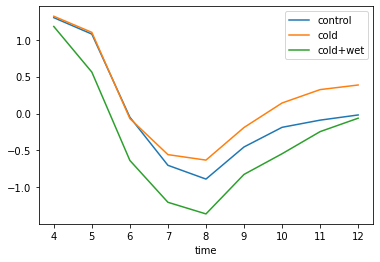

In [23]:
cold =df_norm[df_norm['lt_32']>1]
icy = df_norm[(df_norm['lt_32']>1) & (df_norm['p01i']>0)]

df_norm.groupby(df_norm.index.hour).mean()['speed'].plot(label='control')
cold.groupby(cold.index.hour).mean()['speed'].plot(label='cold')
icy.groupby(icy.index.hour).mean()['speed'].plot(label='cold+wet')
plt.legend()